In [13]:
import pandas as pd
import numpy as np
from time import time
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm import tqdm

In [14]:
df = pd.read_csv('../../data/expanded_with_features_non-linear.csv')
df = df[df.language == 'English'].reset_index(drop=True)
df.head(5)

,language,sentence,vertex,vertex.1,n,degree,closeness,harmonic,betweeness,load,...,information,current_flow_betweeness,percolation,second_order,laplacian,is_leaf,pos_norm,max_branch_size,subtree_entropy,is_root
0,English,2,1,10,16,0.200000,0.277778,6.292857,0.514286,0.514286,...,0.018519,5.142857e-01,0.514286,41.856899,0.234043,0,0.0625,29,0.047279,1
1,English,2,13,29,16,0.133333,0.300000,6.016667,0.514286,0.514286,...,0.020000,5.142857e-01,0.514286,36.986484,0.170213,0,0.8125,16,1.176009,0
2,English,2,15,21,16,0.133333,0.312500,6.150000,0.533333,0.533333,...,0.020833,5.333333e-01,0.533333,34.292856,0.170213,0,0.9375,29,0.047279,0
3,English,2,3,19,16,0.200000,0.312500,6.759524,0.590476,0.590476,...,0.020833,5.904762e-01,0.590476,34.292856,0.255319,0,0.1875,18,0.972914,0
4,English,2,12,28,16,0.066667,0.241935,4.784524,0.000000,0.000000,...,0.016129,2.537653e-17,0.000000,50.199602,0.085106,1,0.7500,19,1.101996,0


In [15]:
# Hold-out split by sentence (20% of sentences)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, hold_idx = next(gss.split(df, df.is_root, groups=df.sentence))
train_df = df.iloc[train_idx].reset_index(drop=True)
hold_df  = df.iloc[hold_idx].reset_index(drop=True)

In [16]:
FEATURES = [
  'degree','closeness','harmonic','betweeness','load','pagerank',
  'eigenvector','katz','information','current_flow_betweeness',
  'percolation','second_order','laplacian',
  'is_leaf','pos_norm','max_branch_size','subtree_entropy'
]
X_train, y_train, sent_train = (
    train_df[FEATURES].values,
    train_df.is_root.values,
    train_df.sentence.values
)
X_hold, y_hold, sent_hold = (
    hold_df[FEATURES].values,
    hold_df.is_root.values,
    hold_df.sentence.values
)

In [17]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_hold_s  = scaler.transform(X_hold)

In [18]:
def root_score(sent_ids, y_true, probs):
    dfp = pd.DataFrame({'sent': sent_ids, 'y': y_true, 'p': probs})
    picks = dfp.loc[dfp.groupby('sent')['p'].idxmax()]
    return (picks.y == 1).mean()

In [19]:
param_grid = {
    'n_estimators':     [100, 200, 500],
    'max_depth':        [5, 10, 20, None],
    'min_samples_leaf': [5, 10, 20],
    'max_features':     ['sqrt', 'log2', 0.5],
    'class_weight':     ['balanced_subsample']
}

In [20]:
best_oob = -1.0
best_params = None

In [21]:
start = time()
for ne in param_grid['n_estimators']:
    for md in param_grid['max_depth']:
        for msl in param_grid['min_samples_leaf']:
            for mf in param_grid['max_features']:
                rf = RandomForestClassifier(
                    n_estimators=ne,
                    max_depth=md,
                    min_samples_leaf=msl,
                    max_features=mf,
                    class_weight='balanced_subsample',
                    oob_score=True,
                    random_state=42,
                    n_jobs=-1
                )
                rf.fit(X_train_s, y_train)
                # get per-sample OOB probability for class=1
                oob_probs = rf.oob_decision_function_[:,1]
                oob_root  = root_score(sent_train, y_train, oob_probs)
                print(f"OOB root‐score={oob_root:.3f} | ",
                      f"ne={ne}, md={md}, leaf={msl}, mf={mf}")
                if oob_root > best_oob:
                    best_oob = oob_root
                    best_params = dict(
                        n_estimators=ne, max_depth=md,
                        min_samples_leaf=msl, max_features=mf
                    )
print(f"\nTuning done in {timedelta(seconds=time()-start)}")
print("Best OOB root‐score:", best_oob)
print("Best RF params:", best_params)

OOB root‐score=0.255 |  ne=100, md=5, leaf=5, mf=sqrt
OOB root‐score=0.255 |  ne=100, md=5, leaf=5, mf=log2
OOB root‐score=0.250 |  ne=100, md=5, leaf=5, mf=0.5
OOB root‐score=0.263 |  ne=100, md=5, leaf=10, mf=sqrt
OOB root‐score=0.263 |  ne=100, md=5, leaf=10, mf=log2
OOB root‐score=0.270 |  ne=100, md=5, leaf=10, mf=0.5
OOB root‐score=0.263 |  ne=100, md=5, leaf=20, mf=sqrt
OOB root‐score=0.263 |  ne=100, md=5, leaf=20, mf=log2
OOB root‐score=0.263 |  ne=100, md=5, leaf=20, mf=0.5
OOB root‐score=0.223 |  ne=100, md=10, leaf=5, mf=sqrt
OOB root‐score=0.223 |  ne=100, md=10, leaf=5, mf=log2
OOB root‐score=0.247 |  ne=100, md=10, leaf=5, mf=0.5
OOB root‐score=0.253 |  ne=100, md=10, leaf=10, mf=sqrt
OOB root‐score=0.253 |  ne=100, md=10, leaf=10, mf=log2
OOB root‐score=0.250 |  ne=100, md=10, leaf=10, mf=0.5
OOB root‐score=0.255 |  ne=100, md=10, leaf=20, mf=sqrt
OOB root‐score=0.255 |  ne=100, md=10, leaf=20, mf=log2
OOB root‐score=0.270 |  ne=100, md=10, leaf=20, mf=0.5
OOB root‐scor

In [22]:
# Refit on ALL training data with those best params
rf_final = RandomForestClassifier(
    **best_params,
    class_weight='balanced_subsample',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_s, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.5, min_samples_leaf=20, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42)

In [24]:
# Final OOB & hold‐out
final_oob = root_score(sent_train, y_train, rf_final.oob_decision_function_[:,1])
hold     = root_score(sent_hold,  y_hold,  rf_final.predict_proba(X_hold_s)[:,1])
print(f"Final OOB root‐score on TRAIN:      {final_oob:.3f}")
print(f"Hold‐out root‐score on HELD‐OUT:     {hold:.3f}")

Final OOB root‐score on TRAIN:      0.282
Hold‐out root‐score on HELD‐OUT:     0.270


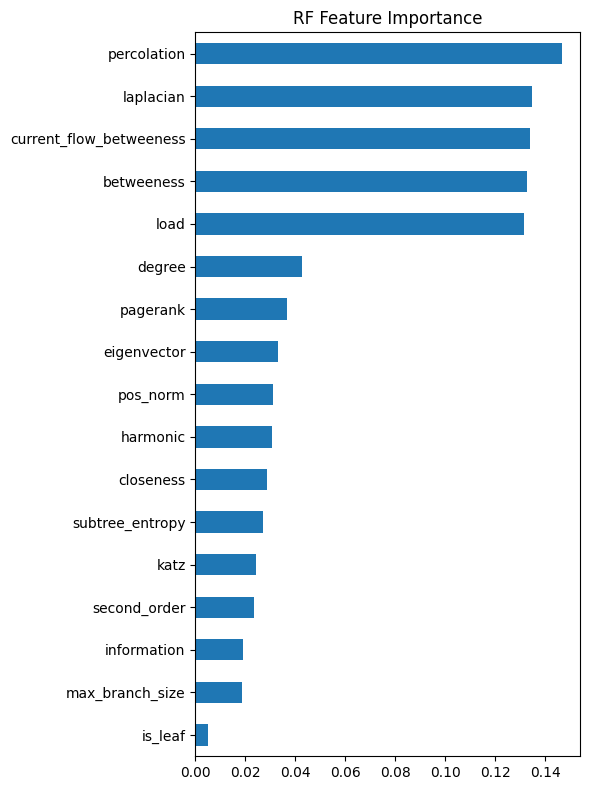

In [25]:
# Feature importances
importances = pd.Series(rf_final.feature_importances_, index=FEATURES)
importances.sort_values().plot.barh(figsize=(6,8), title="RF Feature Importance")
plt.tight_layout()
plt.show()